In [224]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans

In [254]:
video = cv.VideoCapture("Video1_husky.mp4")

while video.isOpened():
    ret, frame = video.read()

    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    cv.imshow('frame', frame)
    if cv.waitKey(1) == ord('q'):
        break

video.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


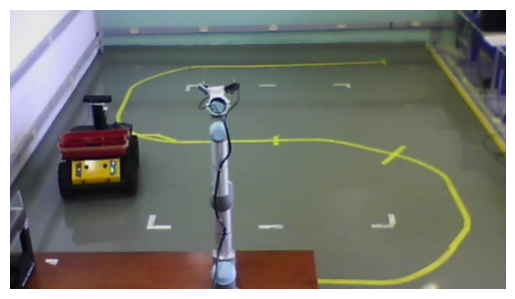

In [228]:
plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [200]:
frame = frame.astype(np.double)
frame = frame / 255.

frame_channels = cv.split(frame)

In [202]:
hist_blue = cv.calcHist((frame * 255).astype(np.uint8), [0], None, [256], [0,256])
hist_green = cv.calcHist((frame * 255).astype(np.uint8), [1], None, [256], [0, 256])
hist_red = cv.calcHist((frame * 255).astype(np.uint8), [2], None, [256], [0, 256])

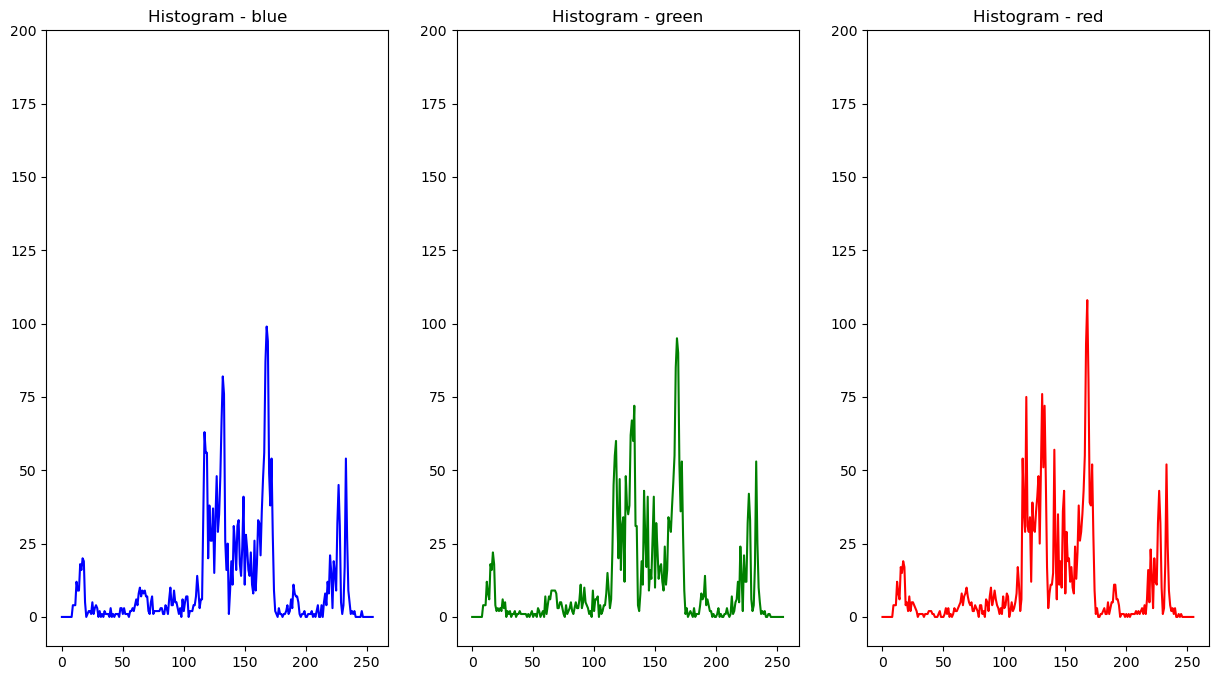

In [204]:
hist = [hist_blue, hist_green, hist_red]
colors = ['blue', 'green', 'red']

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 8))

for i in range(3):
    axs[i].plot(hist[i], color = colors[i])
    axs[i].set_title('Histogram - ' + colors[i])
    axs[i].set_ylim(-10, 200)

plt.show()

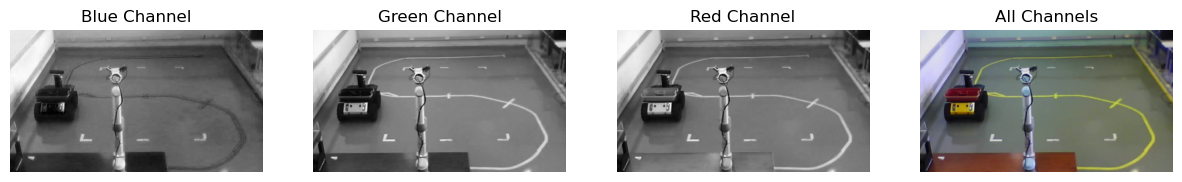

In [206]:
titles = ['Blue Channel', 'Green Channel', 'Red Channel']
fig, axs1 = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 10))

for i in range(3):
    axs1[i].imshow(frame_channels[i], cmap = 'gray')
    axs1[i].set_title(titles[i])
    axs1[i].set_axis_off()

axs1[3].imshow(cv.cvtColor((frame * 255).astype(np.uint8), cv.COLOR_BGR2RGB))
axs1[3].set_title('All Channels')
axs1[3].set_axis_off()
plt.show()

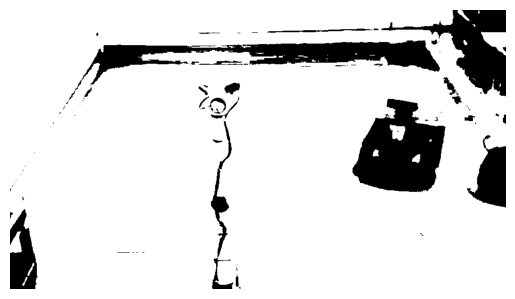

In [138]:
ret, bin_img = cv.threshold((frame_channels[2] * 255).astype(np.uint8), 75, 255, cv.THRESH_BINARY)
plt.imshow(bin_img, cmap = 'gray')
plt.axis('off')
plt.show()

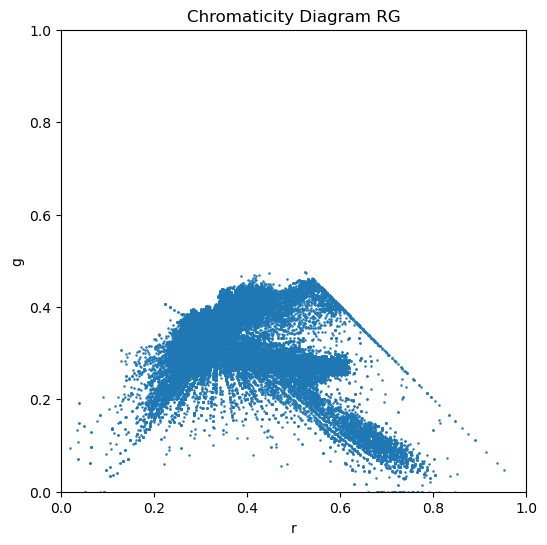

In [208]:
gray = frame_channels[0] + frame_channels[1] + frame_channels[2]
r = frame_channels[2] / gray
g = frame_channels[1] / gray
b = frame_channels[0] / gray

fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(x = r, y = g, s = 0.6)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('r')
ax.set_ylabel('g')
ax.set_title('Chromaticity Diagram RG')
plt.show()

In [210]:
k = 3
data = np.column_stack((r.ravel(), g.ravel()))
kmean = KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
kmean.fit(data)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [211]:
center = kmean.cluster_centers_
labels = kmean.labels_
labels_image = labels.reshape(540, 960)

In [146]:
center

array([[0.30625375, 0.35266378],
       [0.6963814 , 0.11472913],
       [0.39534376, 0.40592557],
       [0.34223447, 0.35546182],
       [0.51969513, 0.27606389],
       [0.3128683 , 0.31592188]])

In [29]:
# Red =~ [0.6, 0.3]

expected_red = [0.6, 0.3]
distances = np.linalg.norm(x = (center-expected_red), axis = 1)
red_idx = np.argmin(distances)
red_mask = (labels_image == red_idx).astype(np.uint8) * 255

In [214]:
binary_img = []
for cluster in range(k):
    binary_mask = (labels_image == cluster).astype(np.uint8) * 255
    binary_img.append(binary_mask)

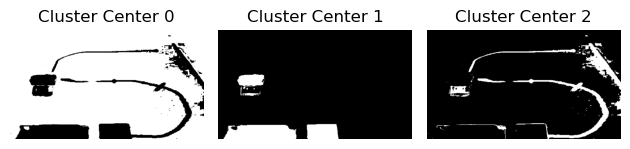

In [216]:
fig, axs = plt.subplots(nrows = 1, ncols = 3)

axs = axs.flatten()
for i in range(k):
    axs[i].imshow(binary_img[i], cmap = 'gray')
    axs[i].set_axis_off()
    axs[i].set_title('Cluster Center ' + str(i))

plt.tight_layout()

In [35]:
# Contour of the image


# findContour function found several contours with area equal 0, thus the loop
areas = []
M = []
cXs = []
cYs = []
for i in range(k):
    M.append([])
    areas.append([])
    cXs.append([])
    cYs.append([])

    contours, hierarchy = cv.findContours(binary_img[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for c in contours:
        if cv.contourArea(c) != 0:
            m = cv.moments(c)
            M[i].append(m)
            
            area = cv.contourArea(c)
            areas[i].append(area)
            if (area > 700) & (area < 9000):
                cX = int(m['m10']/m['m00'])
                
                cXs[i].append(cX)
                cY = int(m['m01']/m['m00'])
                
                cYs[i].append(cY)
                #cv.circle(img = red, center = (cX, cY), radius = 5, color = (128, 128, 128), thickness = -1)


In [37]:
    
    if len(cXs) > 1:
        for i in range(len(cXs)-1):
            cX_previous = cXs[i]
            cX_actual = cXs[i+1]
            cY_previous = cYs[i]
            cY_actual = cYs[i+1]
            dist = ((cX_previous-cX_actual)**2+(cY_previous-cY_actual)**2)**(1/2)
            if dist <= 100:
                cX = int((cX_previous+cX_actual)/2)
                cY = int((cY_previous+cY_actual)/2)
                cv.circle(img = red, center = (cX, cY), radius = 5, color = (128, 128, 128), thickness = -1)
    else:
        cv.circle(img = red, center = (cX, cY), radius = 5, color = (128, 128, 128), thickness = -1)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [202]:
soma = []
for i in range(k):
    soma.append(sum(areas[i]))

soma

[20782.5, 486584.0, 20613.5]

In [41]:
areas[1]

[0.5,
 22397.5,
 2.0,
 16.0,
 4.0,
 540.5,
 4.0,
 6.0,
 10823.0,
 3.0,
 4.0,
 692.5,
 2.0,
 6.0,
 1.5,
 5.0,
 10.0,
 136.5,
 518.0,
 4773.0,
 6.0,
 2.0,
 2.0]

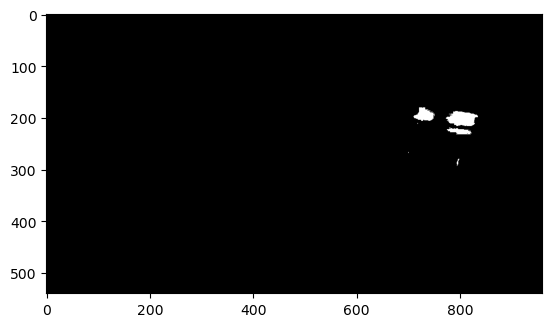

In [152]:
plt.imshow(binary_img[1], cmap = 'gray')

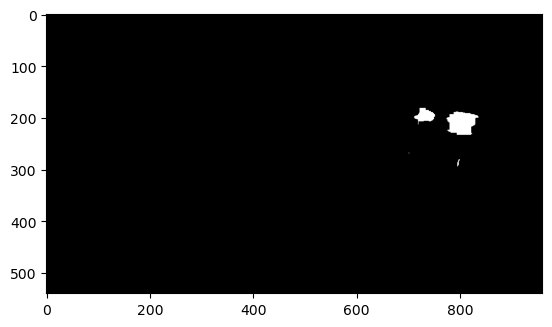

In [154]:
kernel = cv.getStructuringElement(cv.MORPH_RECT, (10,10))  # Define o tamanho do kernel para fechamento
red_mask = cv.morphologyEx(binary_img[1], cv.MORPH_CLOSE, kernel)  # Fecha buracos na máscara
plt.imshow(red_mask, cmap = 'gray')

In [157]:
Mtest = []
areatest = []
contours, hierarchy = cv.findContours(red_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
for c in contours:
        if cv.contourArea(c) != 0:
            m = cv.moments(c)
            Mtest.append(m)
            
            area = cv.contourArea(c)
            areatest.append(area)

In [159]:
areatest

[18.5, 1895.5, 651.5]

In [174]:
rect = cv.minAreaRect(contours[1])
rect

((702.0, 269.5), (1.0, 0.0), -90.0)

In [178]:
rect[1][0]

1.0

In [170]:
Mtest

[{'m00': 18.5,
  'm10': 14752.666666666666,
  'm01': 5336.166666666666,
  'm20': 11764404.916666666,
  'm11': 4255231.208333333,
  'm02': 1539388.0833333333,
  'm30': 9381451368.300001,
  'm21': 3393263362.7666664,
  'm12': 1227543544.9333334,
  'm03': 444148017.05,
  'mu20': 17.144894894212484,
  'mu11': -49.23010510485619,
  'mu02': 216.47822822839953,
  'mu30': 9.753158569335938,
  'mu21': -32.84549317270648,
  'mu12': 92.82717986102216,
  'mu03': -183.22882616519928,
  'nu20': 0.05009465272231552,
  'nu11': -0.14384252769863023,
  'nu02': 0.6325149108207438,
  'nu30': 0.006625458898345359,
  'nu21': -0.02231240920206496,
  'nu12': 0.06305881940155818,
  'nu03': -0.12446993946826093},
 {'m00': 1895.5,
  'm10': 1524107.1666666665,
  'm01': 401167.5,
  'm20': 1225842041.9166665,
  'm11': 322550928.875,
  'm02': 85153986.25,
  'm30': 986235874282.3501,
  'm21': 259416207227.44998,
  'm12': 68463466112.45,
  'm03': 18128437339.850002,
  'mu20': 359237.65146255493,
  'mu11': -14231.65454

In [242]:
hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

# Intervalos para vermelho (duas faixas devido à circularidade do HSV)
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([160, 100, 100])
upper_red2 = np.array([180, 255, 255])

# Intervalo para amarelo
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([40, 255, 255])

# Criar máscaras
mask_red1 = cv.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv.inRange(hsv, lower_red2, upper_red2)
mask_yellow = cv.inRange(hsv, lower_yellow, upper_yellow)

# Máscara final para vermelho
mask_red = cv.bitwise_or(mask_red1, mask_red2)

# Aplicar máscaras
image_no_yellow = cv.bitwise_and(frame, frame, mask=cv.bitwise_not(mask_yellow))


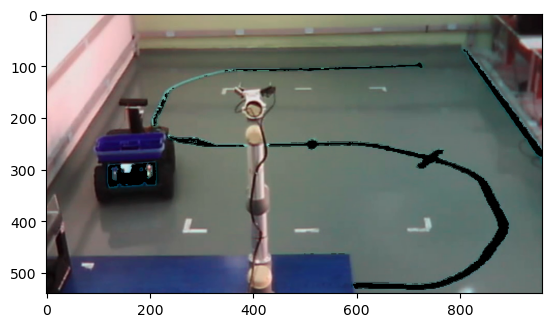

In [244]:
plt.imshow(image_no_yellow)

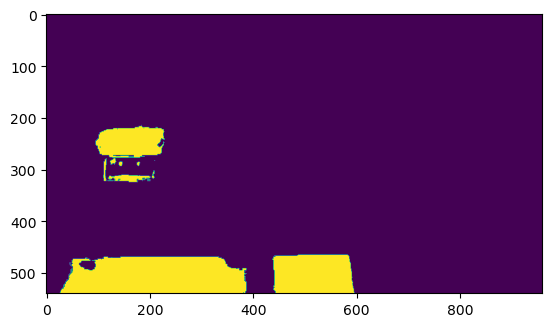

In [265]:
plt.imshow(binary_img[1])